# sigma54-RNAP-Cy3 binding to 597P255

Fig. 1E in [RNA polymerase approaches its promoter without
long-range sliding along DNA](https://www.pnas.org/content/pnas/110/24/9740.full.pdf)

## Setup

In [1]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import pi, resample
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos, HMM
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.imscroll import time_to_first_binding

from tapqir.utils.mle_analysis import train, ttfb_model, ttfb_guide

## View Data

In [2]:
# load glimpse
path_data = Path("/shared/centaur/paper/sigma54RNAPCy3-597P255")
# glimpse = GlimpseDataset(path_data)

# load model & parameters
model = Cosmos(verbose=False)
model.load(path_data, data_only=False)

### AOIs

In [3]:
glimpse.aoiinfo["test"]

,frame,ave,x,y,pixnum
aoi,,,,,
1,4576.0,3.0,465.800874,166.115977,7.0
2,4576.0,3.0,461.890749,158.269997,7.0
3,4576.0,3.0,462.586798,216.967306,7.0
4,4576.0,3.0,450.603082,216.631839,7.0
5,4576.0,3.0,438.751026,248.921980,7.0
...,...,...,...,...,...
98,4576.0,3.0,288.674885,169.382946,7.0
99,4576.0,3.0,442.985487,60.207967,7.0
100,4576.0,3.0,337.499860,78.386376,7.0


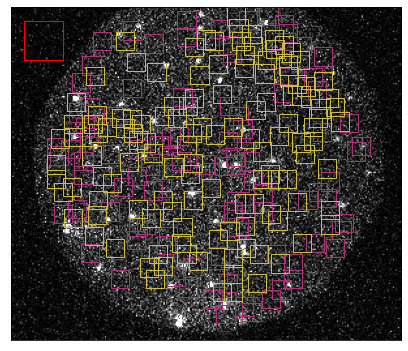

In [4]:
plt.figure(figsize=(7, 7))

frame = 2078 - 47
# plot selected area of the image
plt.imshow(glimpse[frame][256:], cmap="gray",
           vmin=model.data.vmin, vmax=model.data.vmax)

for aoi in glimpse.aoiinfo["test"].index:
    # on-target area
    y_pos = round(glimpse.aoiinfo["test"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["test"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5 - 256
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#AA3377", lw=1, facecolor="none"))

for aoi in glimpse.aoiinfo["control"].index:
    # off-target area
    y_pos = round(glimpse.aoiinfo["control"].at[aoi, "y"]
                  + glimpse.cumdrift.at[frame, "dy"] - 6.5) - 0.5
    x_pos = round(glimpse.aoiinfo["control"].at[aoi, "x"]
                  + glimpse.cumdrift.at[frame, "dx"] - 6.5) - 0.5 - 256
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14,
                                  edgecolor="#CCBB44", lw=1, facecolor="none"))
    

plt.gca().add_patch(Rectangle((10, 10), 30, 30,
                    edgecolor="r", lw=1, facecolor="none"))
    
plt.xticks([], [])
plt.yticks([], [])
plt.show()

### Driftlist

In [5]:
glimpse.cumdrift

,dx,dy
frame,,
170,3.223052,0.140329
171,3.223052,0.140329
172,3.223531,0.142883
173,3.223993,0.145426
174,3.224437,0.147959
...,...,...
4572,-0.002196,-0.001024
4573,-0.001778,-0.000818
4574,-0.001350,-0.000612


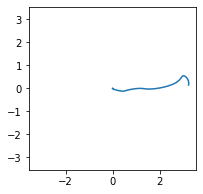

In [6]:
plt.figure(figsize=(3,3))
plt.plot(glimpse.cumdrift["dx"], glimpse.cumdrift["dy"])
lim = glimpse.cumdrift.abs().max().max() * 1.1
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.show()

### Offset

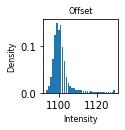

In [3]:
plt.figure(figsize=(1.35,1.35))
plt.bar(model.data.offset.samples, model.data.offset.weights)
plt.title("Offset", fontsize=8)
plt.ylabel("Density", fontsize=8)
plt.xlabel("Intensity", fontsize=8)
plt.show()

### Global parameters

In [4]:
model.statistics

,Mean,95% LL,95% UL
gain,11.954681777549816,11.936278,11.972509
proximity,0.4465641529761136,0.440775,0.451661
lamda,0.10286486102876954,0.101074,0.104513
SNR,3.385000922211679,NaN,NaN
MCC,0.9672306789463442,NaN,NaN
Recall,0.9465667137690705,NaN,NaN
Precision,0.9943642127509686,NaN,NaN
TN,407537,NaN,NaN
FP,224,NaN,NaN
FN,2231,NaN,NaN


## Figures

### Figure 4

In [3]:
model.load_checkpoint(param_only=True)
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)

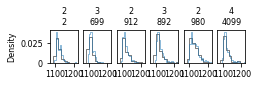

In [4]:
aois = [2, 3, 2, 3, 2, 4]
frames = [2, 699, 912, 892, 980, 4099]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data.ontarget.images[n, f].flatten().numpy(),
        range=(1070, model.data.vmax+50),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    
    model.n = torch.tensor([n])
    samples = predictive()
    img_sample = model.data.offset.samples[samples["d/offset"][0, 0, f]] + samples["d/data"][0, 0, f]
    plt.hist(
        img_sample.flatten().numpy(),
        range=(1070, model.data.vmax+50),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(1070, model.data.vmax+50)
    plt.xticks([1100, 1200], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/597P255-hist.svg")

plt.show()

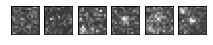

In [5]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data.ontarget.images[n, f].numpy(), vmin=1070, vmax=1200, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/597P255-data.png", dpi=600)

plt.show()

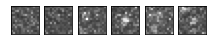

In [6]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    model.n = torch.tensor([n])
    samples = predictive()
    img_sample = model.data.offset.samples[samples["d/offset"][0, 0, f]] + samples["d/data"][0, 0, f]
    plt.imshow(img_sample.numpy(), vmin=1070, vmax=1200, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/597P255-sample.png", dpi=600)

plt.show()

### Figure 7

#### Ratergram

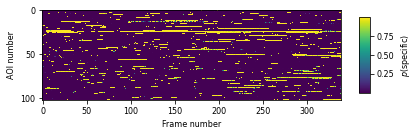

In [14]:
# on-target
ttfb = time_to_first_binding(model.params["z_map"])
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.params["p(specific)"][:, ::13], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

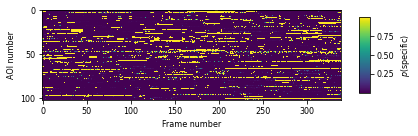

In [15]:
# off-target
plt.figure(figsize=(6, 2))
plt.imshow(1 - (1 - model.params["d/j_probs"][:, :, ::13]).prod(0), aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

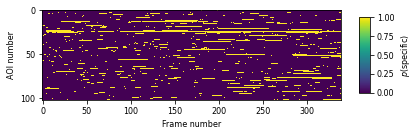

In [17]:
# spotpicker
ttfb = time_to_first_binding(model.data.ontarget.labels["z"])
# sort ttfb
sdx = np.flip(np.argsort(ttfb))


plt.figure(figsize=(6, 2))
plt.imshow(model.data.ontarget.labels["z"][:, ::13], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.show()

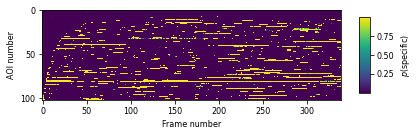

In [46]:
# sorted on-target
ttfb = time_to_first_binding(model.params["z_map"])
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)

plt.figure(figsize=(6, 2))
plt.imshow(model.params["p(specific)"][sdx][:, ::13], aspect="equal", interpolation="none")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
cbar = plt.colorbar(aspect=7, shrink=0.7)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label=r"$p(\mathsf{specific})$", size=8)
plt.tight_layout()
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure7/597P255-rastegram.png", dpi=900)
plt.show()

#### Tapqir fit

In [5]:
control = None
Tmax = model.data.ontarget.F

z = dist.Bernoulli(model.params["p(specific)"]).sample((1000,))
data = time_to_first_binding(z)

In [8]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data.cuda(), control=control, Tmax=Tmax, jit=False
)

In [11]:
results = pd.DataFrame(columns=["Mean", "95% LL", "95% UL"])

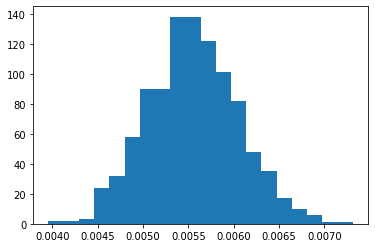

In [10]:
plt.hist(pyro.param("ka").data.squeeze().cpu().numpy(), bins=20)
plt.show()

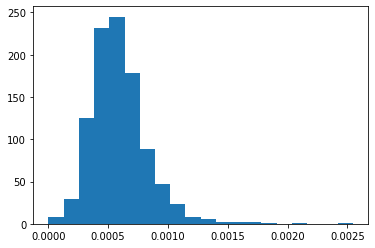

In [29]:
plt.hist(pyro.param("kns").data.squeeze().cpu().numpy(), bins=20)
plt.show()

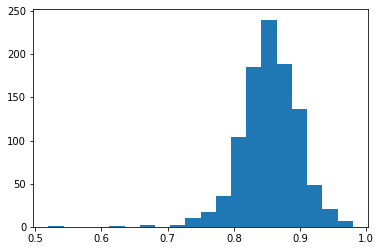

In [30]:
plt.hist(pyro.param("Af").data.squeeze().cpu().numpy(), bins=20)
plt.show()

In [12]:
results.loc["ka", "Mean"] = pyro.param("ka").mean().item()
ll, ul = pi(pyro.param("ka").data.squeeze(), 0.95, dim=0)
results.loc["ka", "95% LL"], results.loc["ka", "95% UL"] = ll.item(), ul.item()

In [14]:
results.loc["kns", "Mean"] = pyro.param("kns").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["kns", "95% LL"], results.loc["kns", "95% UL"] = ll.item(), ul.item()

In [17]:
results.loc["Af", "Mean"] = pyro.param("Af").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["Af", "95% LL"], results.loc["Af", "95% UL"] = ll.item(), ul.item()

In [18]:
results

,Mean,95% LL,95% UL
ka,0.005549,0.004572,0.006558
kns,0.000591,0.000223,0.001102
Af,0.854519,0.000223,0.001102


In [22]:
torch.set_default_tensor_type(torch.FloatTensor)

nz = (data == 0).sum(1, keepdim=True)
n = (data == Tmax).sum(1, keepdim=True)
N = data.shape[1]

In [23]:
fraction_bound = (data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

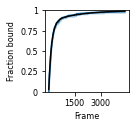

In [27]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (results.loc["Af", "Mean"]*(1 - torch.exp(-(results.loc["ka", "Mean"]+results.loc["kns", "Mean"]) * torch.arange(Tmax))) +
    (1 - results.loc["Af", "Mean"])*(1 - torch.exp(-results.loc["kns", "Mean"] * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure7/597P255-tapqir.svg")
plt.show()

#### Spotpicker fit

In [28]:
Tmax = model.data.ontarget.F

spotpicker_data = time_to_first_binding(model.data.ontarget.labels["z"])
spotpicker_data = torch.tensor(spotpicker_data, dtype=torch.float)
spotpicker_control = time_to_first_binding(model.data.offtarget.labels["z"])
spotpicker_control = torch.tensor(spotpicker_control, dtype=torch.float)

bootstrap_data = torch.stack(
    [resample(spotpicker_data, num_samples=len(spotpicker_data), replacement=True) for _ in range(1000)],
    dim=0
)
bootstrap_control = torch.stack(
    [resample(spotpicker_control, num_samples=len(spotpicker_control), replacement=True) for _ in range(1000)],
    dim=0
)

In [31]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=bootstrap_data.cuda(), control=bootstrap_control.cuda(), Tmax=Tmax, jit=False
)

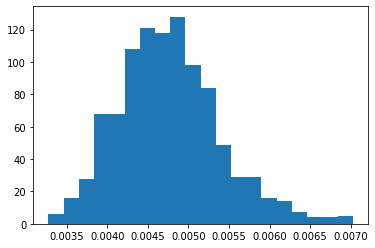

In [32]:
plt.hist(pyro.param("ka").data.squeeze().cpu().numpy(), bins=20)
plt.show()

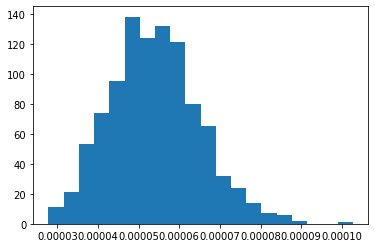

In [33]:
plt.hist(pyro.param("kns").data.squeeze().cpu().numpy(), bins=20)
plt.show()

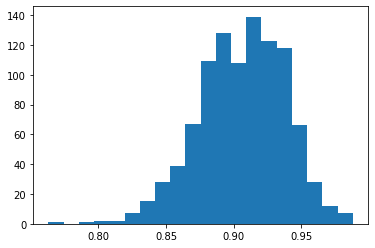

In [34]:
plt.hist(pyro.param("Af").data.squeeze().cpu().numpy(), bins=20)
plt.show()

In [35]:
results.loc["ka_sp", "Mean"] = pyro.param("ka").mean().item()
ll, ul = pi(pyro.param("ka").data.squeeze(), 0.95, dim=0)
results.loc["ka_sp", "95% LL"], results.loc["ka_sp", "95% UL"] = ll.item(), ul.item()

In [36]:
results.loc["kns_sp", "Mean"] = pyro.param("kns").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["kns_sp", "95% LL"], results.loc["kns_sp", "95% UL"] = ll.item(), ul.item()

In [37]:
results.loc["Af_sp", "Mean"] = pyro.param("Af").mean().item()
ll, ul = pi(pyro.param("kns").data.squeeze(), 0.95, dim=0)
results.loc["Af_sp", "95% LL"], results.loc["Af_sp", "95% UL"] = ll.item(), ul.item()

In [38]:
results

,Mean,95% LL,95% UL
ka,0.005549,0.004572,0.006558
kns,0.000591,0.000223,0.001102
Af,0.854519,0.000223,0.001102
ka_sp,0.00476,0.003676,0.006161
kns_sp,0.000054,0.000034,0.000077
Af_sp,0.906282,0.000034,0.000077


In [41]:
torch.set_default_tensor_type(torch.FloatTensor)

nz = (bootstrap_data == 0).sum(1, keepdim=True)
n = (bootstrap_data == Tmax).sum(1, keepdim=True)
N = bootstrap_data.shape[1]

nzc = (bootstrap_control == 0).sum(1, keepdim=True)
nc = (bootstrap_control == Tmax).sum(1, keepdim=True)
Nc = bootstrap_control.shape[1]

In [42]:
fraction_bound = (bootstrap_data.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fb_ll, fb_ul = pi(fraction_bound, 0.68, dim=0)

fraction_boundc = (bootstrap_control.unsqueeze(-1) < torch.arange(Tmax)).float().mean(1)
fbc_ll, fbc_ul = pi(fraction_boundc, 0.68, dim=0)

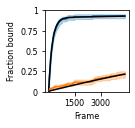

In [45]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)

plt.fill_between(
    torch.arange(Tmax),
    fb_ll, fb_ul,
    alpha=0.3, color="C0"
)
plt.plot(torch.arange(Tmax), fraction_bound.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nz / N +
    (1 - nz / N) *
    (results.loc["Af_sp", "Mean"]*(1 - torch.exp(-(results.loc["ka_sp", "Mean"]+results.loc["kns_sp", "Mean"]) * torch.arange(Tmax))) +
    (1 - results.loc["Af_sp", "Mean"])*(1 - torch.exp(-results.loc["kns_sp", "Mean"] * torch.arange(Tmax))))).mean(0),
    color="k"
)

plt.fill_between(
    torch.arange(Tmax),
    fbc_ll, fbc_ul,
    alpha=0.3, color="C1"
)
plt.plot(torch.arange(Tmax), fraction_boundc.mean(0))


plt.plot(
    torch.arange(Tmax),
    (nzc / Nc +
    (1 - nzc / Nc) *
    (1 - torch.exp(-results.loc["kns_sp", "Mean"] * torch.arange(Tmax)))).mean(0),
    color="k"
)

plt.xticks([1500, 3000], fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel("Frame", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure7/597P255-spotpicker.svg")
plt.show()